In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main
!pip install transformers==4.45.2

In [6]:
# -------------------Set model properties-----------------------------------
model_name_or_path = "openai/whisper-small"
language = "bengali"
task = "transcribe"

In [7]:
#---------------------------Load Dataset--------------------------------------
from datasets import load_dataset, DatasetDict

# Load the full dataset
full_train = load_dataset("imonghose/bengali-asr-data", split="train")
full_test = load_dataset("imonghose/bengali-asr-data", split="test")



# Get dataset sizes
train_size = len(full_train)
test_size = len(full_test)

# Compute the original train-test ratio
original_ratio = test_size / train_size

# Compute the new test size corresponding to 60% train size
new_train_size = int(0.05 * train_size)
new_test_size = int(0.2 * test_size)

train_sample = full_train.shuffle(seed=42).select(range(new_train_size))
test_sample = full_test.shuffle(seed=42).select(range(new_test_size))

# Create a new dataset dictionary
bangla_dataset = DatasetDict({
    "train": train_sample,
    "test": test_sample
})


Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [8]:
#-----------Check dataset shape----------
bangla_dataset.shape

{'train': (7978, 3), 'test': (2042, 3)}

In [9]:
#-----------Check dataset structure----------
bangla_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'length'],
        num_rows: 7978
    })
    test: Dataset({
        features: ['audio', 'sentence', 'length'],
        num_rows: 2042
    })
})

In [10]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path,language=language,task=task)

In [11]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path,language=language,task=task)

In [12]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

In [13]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [14]:
#-------------------Check sampling rate before downsampling-----------------
print(bangla_dataset["train"][16])

{'audio': {'path': None, 'array': array([-0.00280762, -0.00262451, -0.00244141, ..., -0.00317383,
        0.00238037,  0.00650024]), 'sampling_rate': 16000}, 'sentence': 'পদ্মা সেতু প্রকল্প পরিচালক', 'length': 2.5}


In [15]:
#--------------------Downsample to 16 KHz--------------------------
from datasets import Audio

bangla_dataset = bangla_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [16]:
#-------------------Check sampling rate after downsampling-----------------
print(bangla_dataset["train"][0])

{'audio': {'path': None, 'array': array([ 0.00189209,  0.0015564 ,  0.00189209, ...,  0.00039673,
        0.00033569, -0.00079346]), 'sampling_rate': 16000}, 'sentence': 'আবদুর রহমান বয়াতি', 'length': 3.2}


In [18]:
#------------------Custom preprocessing function with Spec Augment for dataset-----------------------------
import torch
import random

def apply_spec_augment(mel_spec, time_mask_param=20, freq_mask_param=10, num_time_masks=2, num_freq_masks=2):
    """Applies SpecAugment on a log-Mel spectrogram."""
    mel_spec = torch.tensor(mel_spec)  # shape: (80, time)

    # Frequency masking
    for _ in range(num_freq_masks):
        f = random.randint(0, freq_mask_param)
        f0 = random.randint(0, mel_spec.shape[0] - f)
        mel_spec[f0:f0+f, :] = 0

    # Time masking
    for _ in range(num_time_masks):
        t = random.randint(0, time_mask_param)
        t0 = random.randint(0, mel_spec.shape[1] - t)
        mel_spec[:, t0:t0+t] = 0

    return mel_spec.numpy()

def prepare_dataset(batch):
    audio = batch["audio"]
    input_features = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # Apply SpecAugment only during training
    if "train" in batch.get("__index_level__", "") or "train" in batch.get("split", ""):
        input_features = apply_spec_augment(input_features)

    batch["input_features"] = input_features
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch


In [19]:
#-------------------------Execute preprocessing---------------------------
bangla_dataset = bangla_dataset.map(prepare_dataset, remove_columns=bangla_dataset.column_names["train"], num_proc=1)


In [20]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["test"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 2042
})

In [21]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["train"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 7978
})

In [26]:
#-------------------Check first sentence by decoding-----------------------
first_label_ids = bangla_dataset["train"][0]["labels"]  # Get the first label (token IDs)
first_sentence = tokenizer.decode(first_label_ids)  # Decode to text

print(first_sentence)


<|startoftranscript|><|bn|><|transcribe|><|notimestamps|>আবদুর রহমান বয়াতি<|endoftext|>


In [ ]:
# -----------------------------Visualization of sentence token sizes vs frequency (OPTIONAL STEP)------------------------
import matplotlib.pyplot as plt

list_of_transcription_lengths = []

# Extract labels from dataset and compute their lengths
for data in bangla_dataset["train"]:
    list_of_transcription_lengths.append(len(data["labels"]))

# Plot the histogram
plt.hist(list_of_transcription_lengths, bins=50)  # Adjust bins for better visualization
plt.xlabel("Sentence Length (Number of Tokens)")
plt.ylabel("Number of Transcripts")
plt.title("Distribution of Transcription Lengths")
plt.show()


In [16]:
#------------------------------Check true vs prediction on few sentences before fine-tuning------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------7------
True : চলতে পারিনা 
Pred :  चोलते परिना

 
-------8------
True : নিজের স্বজনের জন্য 
Pred :  निजर साजने जन्नो

 
-------9------
True : সে যুদ্ধকেই 
Pred :  शेजुद्द के इए

 


In [27]:
#-------------------------------------Define Data Collator to introduce padding-------------------------------
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [28]:
#----------------------------Load Data Collator-----------------------------
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [1]:
#------------------------Define evaluation metric wer------------------------
import evaluate
wer = evaluate.load("wer")

c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#===================================Custom Evaluation Function for WER Metric with Periodic Plotting===================================
import torch
import pickle
from tqdm import tqdm
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

wer = evaluate.load("wer")
SAVE_PATH = "evaluation_progress.pkl"

def save_progress(progress):
    with open(SAVE_PATH, "wb") as f:
        pickle.dump(progress, f)

def load_progress():
    try:
        with open(SAVE_PATH, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}

def plot_wer(batch_history, wer_history):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(batch_history, wer_history, marker='o', label='WER (%)')
    plt.xlabel('Batches Processed')
    plt.ylabel('WER')
    plt.title('Running WER Evaluation')
    plt.grid(True)
    plt.legend()
    # Set ticks at intervals of 25 starting from 0 to max batch
    max_batch = max(batch_history) if batch_history else 0
    plt.xticks(np.arange(0, max_batch + 1, 25))
    display(plt.gcf())
    plt.close()

def evaluation(model, resume=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    test_dataset = bangla_dataset["test"]
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        collate_fn=data_collator
    )

    model.eval()

    # Load previous progress if resuming
    progress = load_progress() if resume else {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}
    predictions, references = progress["predictions"], progress["references"]
    start_batch = progress["processed_batches"]
    wer_history = progress.get("wer_history", [])
    batch_history = progress.get("batch_history", [])

    for batch_idx, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
        if batch_idx < start_batch:
            continue  # Skip already processed batches

        input_features = batch["input_features"].to(device)
        labels = batch["labels"]

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features, language='bengali', task='transcribe')

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        is_final = (batch_idx == len(test_dataloader) - 1)
        if (batch_idx + 1) % 25 == 0 or is_final:
            current_wer = wer.compute(predictions=predictions, references=references) * 100
            wer_history.append(current_wer)
            batch_history.append(batch_idx + 1)
            plot_wer(batch_history, wer_history)
            save_progress({
                "predictions": predictions,
                "references": references,
                "processed_batches": batch_idx + 1,
                "wer_history": wer_history,
                "batch_history": batch_history
            })

    return wer_history[-1] if wer_history else None


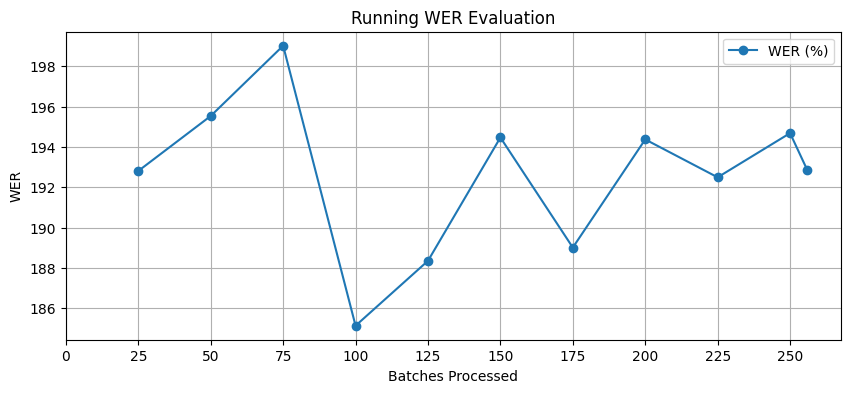

100%|██████████| 256/256 [58:55<00:00, 13.81s/it]


192.83608932407455

In [22]:
# Evaluate WER before the training
torch.cuda.empty_cache()
evaluation(model)

In [22]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

In [31]:
#-----------------------------------Load and add LoRA model to base model-----------------------------------
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

config = LoraConfig(r=32, lora_alpha=64, target_modules=["k_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()
for n,p in model.named_parameters():
    print(n,p.requires_grad)

trainable params: 7,077,888 || all params: 248,812,800 || trainable%: 2.8447
base_model.model.base_model.model.base_model.model.model.encoder.conv1.weight False
base_model.model.base_model.model.base_model.model.model.encoder.conv1.bias False
base_model.model.base_model.model.base_model.model.model.encoder.conv2.weight False
base_model.model.base_model.model.base_model.model.model.encoder.conv2.bias False
base_model.model.base_model.model.base_model.model.model.encoder.embed_positions.weight False
base_model.model.base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.base_layer.weight False
base_model.model.base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight True
base_model.model.base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.lora_B.default.weight True
base_model.model.base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.base_layer.weight False
base_model.model.base_model.mod

In [32]:
#----------------------------Create Training Arguments------------------------------
from transformers import Seq2SeqTrainingArguments,EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="lora-specaugment-checkpoints",
    per_device_train_batch_size=2,  # Reduced from 8 to 2
    per_device_eval_batch_size=2,  # Reduced from 8 to 2
    gradient_accumulation_steps=2,  # Helps with small batch size
    # learning_rate=2e-5, (High)
    learning_rate=1e-5,  #(Medium)
    # learning_rate=5e-6,  #(Low)
    warmup_steps=50,
    num_train_epochs=2,
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=142,
    # save_strategy="epoch",
    save_strategy="steps",
    save_steps=284, 
    save_total_limit=2,
    load_best_model_at_end=True,  # Disabling to save memory
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Mixed precision enabled
    generation_max_length=128,
    logging_steps=25,
    remove_unused_columns=False,
    label_names=["labels"],

    # Add AdamW optimizer and related arguments
    optim="adamw_torch",  # AdamW optimizer from PyTorch
    weight_decay=0.01,  # Regularization to prevent overfitting
    adam_epsilon=1e-8,   # Epsilon for numerical stability
    max_grad_norm=1.0,   # Gradient clipping
    # TensorBoard logging
    logging_dir="./lora-specaugment-tensorboard",  # Directory for TensorBoard logs
    report_to="tensorboard",  # Enables logging to TensorBoard
)

In [33]:
#--------------------------------Create Trainer--------------------------------------
from transformers import Seq2SeqTrainer

# Use only 10% of the test dataset for evaluation
# eval_sample = bangla_dataset["test"].shuffle(seed=42).select(range(int(0.5 * len(bangla_dataset["test"]))))

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=bangla_dataset["train"],
    eval_dataset=bangla_dataset["test"],
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
model.gradient_checkpointing_enable() #Gradient checkpointing helps save memory by recomputing activations during the backward pass.

In [23]:
#--------------------Login to Huggingface (if required)-----------------------------------
from huggingface_hub import notebook_login
notebook_login()

In [34]:
#-------------------------------Start Training with support for checkpointing--------------------------
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, Trainer
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
from transformers.trainer_utils import get_last_checkpoint
from transformers import WhisperForConditionalGeneration

config = LoraConfig(r=32, lora_alpha=64, target_modules=["k_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

checkpoint_path = get_last_checkpoint("lora-specaugment-checkpoints")

if checkpoint_path is not None:
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    peft_base_model = get_peft_model(WhisperForConditionalGeneration.from_pretrained("openai/whisper-small"), config)
    loaded_model_from_checkpoint = PeftModel.from_pretrained(peft_base_model, checkpoint_path).to('cuda')
    model = loaded_model_from_checkpoint
    trainer.model = model  # Load the trained model into the trainer
    trainer.train(resume_from_checkpoint=checkpoint_path)  # Resume training
else:
    print("No checkpoint found, starting from scratch.")
    torch.cuda.empty_cache()
    trainer.train()  # Start training from scratch

No checkpoint found, starting from scratch.


  0%|          | 0/3988 [01:47<?, ?it/s]
                                                  
  1%|          | 25/3988 [00:20<52:09,  1.27it/s]

{'loss': 3.494, 'grad_norm': 6.058389663696289, 'learning_rate': 4.800000000000001e-06, 'epoch': 0.01}


                                                 
  1%|▏         | 50/3988 [00:40<54:23,  1.21it/s]

{'loss': 3.1433, 'grad_norm': 4.127631664276123, 'learning_rate': 9.800000000000001e-06, 'epoch': 0.03}


                                                 
  2%|▏         | 75/3988 [01:02<59:36,  1.09it/s]

{'loss': 2.7502, 'grad_norm': 1.9930387735366821, 'learning_rate': 9.939055358049771e-06, 'epoch': 0.04}


                                                   
  3%|▎         | 100/3988 [01:24<53:42,  1.21it/s]

{'loss': 2.38, 'grad_norm': 2.482468843460083, 'learning_rate': 9.875571356018285e-06, 'epoch': 0.05}


                                                  
  3%|▎         | 125/3988 [01:45<53:44,  1.20it/s]

{'loss': 2.1474, 'grad_norm': 2.7633168697357178, 'learning_rate': 9.812087353986797e-06, 'epoch': 0.06}


  4%|▎         | 142/3988 [02:00<52:45,  1.21it/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.6956344842910767, 'eval_runtime': 540.7526, 'eval_samples_per_second': 3.776, 'eval_steps_per_second': 1.888, 'epoch': 0.07}


                                                       
  4%|▍         | 150/3988 [11:05<14:54:47, 13.99s/it]

{'loss': 1.8942, 'grad_norm': 2.647979259490967, 'learning_rate': 9.748603351955308e-06, 'epoch': 0.08}


                                                     
  4%|▍         | 175/3988 [11:20<38:40,  1.64it/s]

{'loss': 1.7871, 'grad_norm': 2.973283052444458, 'learning_rate': 9.68511934992382e-06, 'epoch': 0.09}


                                                  
  5%|▌         | 200/3988 [11:36<38:45,  1.63it/s]

{'loss': 1.7686, 'grad_norm': 2.732653856277466, 'learning_rate': 9.621635347892332e-06, 'epoch': 0.1}


                                                  
  6%|▌         | 225/3988 [11:51<37:48,  1.66it/s]

{'loss': 1.6977, 'grad_norm': 3.117002487182617, 'learning_rate': 9.558151345860844e-06, 'epoch': 0.11}


                                                  
  6%|▋         | 250/3988 [12:06<38:13,  1.63it/s]

{'loss': 1.6397, 'grad_norm': 3.2185182571411133, 'learning_rate': 9.497206703910616e-06, 'epoch': 0.13}


                                                  
  7%|▋         | 275/3988 [12:22<38:45,  1.60it/s]

{'loss': 1.5686, 'grad_norm': 4.684021949768066, 'learning_rate': 9.433722701879128e-06, 'epoch': 0.14}


  7%|▋         | 284/3988 [12:27<37:19,  1.65it/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.5613138675689697, 'eval_runtime': 225.6095, 'eval_samples_per_second': 9.051, 'eval_steps_per_second': 4.526, 'epoch': 0.14}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                     
  8%|▊         | 300/3988 [16:23<58:54,  1.04it/s]

{'loss': 1.5609, 'grad_norm': 3.5785210132598877, 'learning_rate': 9.37023869984764e-06, 'epoch': 0.15}


                                                  
  8%|▊         | 325/3988 [16:39<37:27,  1.63it/s]

{'loss': 1.5801, 'grad_norm': 3.77211594581604, 'learning_rate': 9.306754697816152e-06, 'epoch': 0.16}


                                                  
  9%|▉         | 350/3988 [16:54<38:48,  1.56it/s]

{'loss': 1.5407, 'grad_norm': 5.243620872497559, 'learning_rate': 9.243270695784664e-06, 'epoch': 0.18}


                                                  
  9%|▉         | 375/3988 [17:10<35:55,  1.68it/s]

{'loss': 1.4978, 'grad_norm': 3.3527112007141113, 'learning_rate': 9.179786693753175e-06, 'epoch': 0.19}


                                                  
 10%|█         | 400/3988 [17:25<37:31,  1.59it/s]

{'loss': 1.4576, 'grad_norm': 4.4697699546813965, 'learning_rate': 9.116302691721687e-06, 'epoch': 0.2}


                                                  
 11%|█         | 425/3988 [17:42<38:34,  1.54it/s]

{'loss': 1.4374, 'grad_norm': 5.640228748321533, 'learning_rate': 9.0528186896902e-06, 'epoch': 0.21}


 11%|█         | 426/3988 [17:42<39:20,  1.51it/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.4680371284484863, 'eval_runtime': 224.8812, 'eval_samples_per_second': 9.08, 'eval_steps_per_second': 4.54, 'epoch': 0.21}


                                                     
 11%|█▏        | 450/3988 [21:43<38:01,  1.55it/s]

{'loss': 1.408, 'grad_norm': 4.4472575187683105, 'learning_rate': 8.989334687658711e-06, 'epoch': 0.23}


                                                  
 12%|█▏        | 475/3988 [21:58<35:11,  1.66it/s]

{'loss': 1.4086, 'grad_norm': 4.44440221786499, 'learning_rate': 8.925850685627223e-06, 'epoch': 0.24}


                                                  
 13%|█▎        | 500/3988 [22:13<34:32,  1.68it/s]

{'loss': 1.3963, 'grad_norm': 5.898105621337891, 'learning_rate': 8.862366683595735e-06, 'epoch': 0.25}


                                                    
 13%|█▎        | 525/3988 [22:44<47:24,  1.22it/s]

{'loss': 1.3499, 'grad_norm': 5.047598838806152, 'learning_rate': 8.798882681564247e-06, 'epoch': 0.26}


                                                  
 14%|█▍        | 550/3988 [23:00<35:24,  1.62it/s]

{'loss': 1.3507, 'grad_norm': 4.100138187408447, 'learning_rate': 8.735398679532759e-06, 'epoch': 0.28}


 14%|█▍        | 568/3988 [23:11<36:03,  1.58it/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.3831866979599, 'eval_runtime': 222.2001, 'eval_samples_per_second': 9.19, 'eval_steps_per_second': 4.595, 'epoch': 0.28}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                     
 14%|█▍        | 575/3988 [26:58<8:01:07,  8.46s/it]

{'loss': 1.3341, 'grad_norm': 3.928354263305664, 'learning_rate': 8.67191467750127e-06, 'epoch': 0.29}


                                                    
 15%|█▌        | 600/3988 [27:14<36:03,  1.57it/s]

{'loss': 1.3068, 'grad_norm': 4.523846626281738, 'learning_rate': 8.610970035551042e-06, 'epoch': 0.3}


                                                  
 16%|█▌        | 625/3988 [27:29<35:03,  1.60it/s]

{'loss': 1.2751, 'grad_norm': 5.543432712554932, 'learning_rate': 8.547486033519554e-06, 'epoch': 0.31}


                                                  
 16%|█▋        | 650/3988 [27:45<34:04,  1.63it/s]

{'loss': 1.2554, 'grad_norm': 4.334437370300293, 'learning_rate': 8.484002031488066e-06, 'epoch': 0.33}


                                                  
 17%|█▋        | 675/3988 [28:00<34:25,  1.60it/s]

{'loss': 1.223, 'grad_norm': 5.744050025939941, 'learning_rate': 8.420518029456578e-06, 'epoch': 0.34}


                                                  
 18%|█▊        | 700/3988 [28:15<33:50,  1.62it/s]

{'loss': 1.2778, 'grad_norm': 6.243919849395752, 'learning_rate': 8.35703402742509e-06, 'epoch': 0.35}


 18%|█▊        | 710/3988 [28:22<34:19,  1.59it/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.3174560070037842, 'eval_runtime': 221.3818, 'eval_samples_per_second': 9.224, 'eval_steps_per_second': 4.612, 'epoch': 0.36}


                                                     
 18%|█▊        | 725/3988 [32:12<57:38,  1.06s/it]

{'loss': 1.2174, 'grad_norm': 6.978433132171631, 'learning_rate': 8.293550025393602e-06, 'epoch': 0.36}


                                                  
 19%|█▉        | 750/3988 [32:28<33:28,  1.61it/s]

{'loss': 1.2326, 'grad_norm': 6.683673858642578, 'learning_rate': 8.230066023362114e-06, 'epoch': 0.38}


                                                  
 19%|█▉        | 775/3988 [32:43<33:30,  1.60it/s]

{'loss': 1.1886, 'grad_norm': 5.335651874542236, 'learning_rate': 8.166582021330626e-06, 'epoch': 0.39}


                                                  
 20%|██        | 800/3988 [32:59<32:24,  1.64it/s]

{'loss': 1.2215, 'grad_norm': 6.283310413360596, 'learning_rate': 8.103098019299137e-06, 'epoch': 0.4}


                                                  
 21%|██        | 825/3988 [33:14<33:13,  1.59it/s]

{'loss': 1.2322, 'grad_norm': 5.992719650268555, 'learning_rate': 8.03961401726765e-06, 'epoch': 0.41}


                                                  
 21%|██▏       | 850/3988 [33:30<33:57,  1.54it/s]

{'loss': 1.2347, 'grad_norm': 4.751510143280029, 'learning_rate': 7.976130015236161e-06, 'epoch': 0.43}


 21%|██▏       | 852/3988 [33:32<33:36,  1.56it/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.2531144618988037, 'eval_runtime': 221.7106, 'eval_samples_per_second': 9.21, 'eval_steps_per_second': 4.605, 'epoch': 0.43}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                     
 22%|██▏       | 875/3988 [37:29<36:26,  1.42it/s]

{'loss': 1.2225, 'grad_norm': 6.066830635070801, 'learning_rate': 7.912646013204673e-06, 'epoch': 0.44}


                                                  
 23%|██▎       | 900/3988 [37:45<33:24,  1.54it/s]

{'loss': 1.1118, 'grad_norm': 4.819008827209473, 'learning_rate': 7.849162011173185e-06, 'epoch': 0.45}


                                                  
 23%|██▎       | 925/3988 [38:01<32:23,  1.58it/s]

{'loss': 1.1615, 'grad_norm': 6.538123607635498, 'learning_rate': 7.785678009141697e-06, 'epoch': 0.46}


                                                  
 24%|██▍       | 950/3988 [38:17<33:17,  1.52it/s]

{'loss': 1.1458, 'grad_norm': 6.381551742553711, 'learning_rate': 7.722194007110209e-06, 'epoch': 0.48}


                                                  
 24%|██▍       | 975/3988 [38:34<33:47,  1.49it/s]

{'loss': 1.1131, 'grad_norm': 5.847382068634033, 'learning_rate': 7.65871000507872e-06, 'epoch': 0.49}


 25%|██▍       | 994/3988 [38:46<32:57,  1.51it/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.2168641090393066, 'eval_runtime': 222.4273, 'eval_samples_per_second': 9.181, 'eval_steps_per_second': 4.59, 'epoch': 0.5}


                                                     
 25%|██▌       | 1000/3988 [42:33<9:51:04, 11.87s/it]

{'loss': 1.1484, 'grad_norm': 5.69575834274292, 'learning_rate': 7.595226003047232e-06, 'epoch': 0.5}


                                                     
 26%|██▌       | 1025/3988 [42:49<31:37,  1.56it/s]

{'loss': 1.0933, 'grad_norm': 7.884382247924805, 'learning_rate': 7.531742001015745e-06, 'epoch': 0.51}


                                                   
 26%|██▋       | 1050/3988 [43:05<30:49,  1.59it/s]

{'loss': 1.1109, 'grad_norm': 7.408238887786865, 'learning_rate': 7.468257998984256e-06, 'epoch': 0.53}


                                                   
 27%|██▋       | 1075/3988 [43:21<31:48,  1.53it/s]

{'loss': 1.0784, 'grad_norm': 6.463969707489014, 'learning_rate': 7.404773996952769e-06, 'epoch': 0.54}


                                                   
 28%|██▊       | 1100/3988 [43:37<30:20,  1.59it/s]

{'loss': 1.1124, 'grad_norm': 8.492817878723145, 'learning_rate': 7.34128999492128e-06, 'epoch': 0.55}


                                                   
 28%|██▊       | 1125/3988 [43:53<31:26,  1.52it/s]

{'loss': 1.0816, 'grad_norm': 10.888021469116211, 'learning_rate': 7.277805992889793e-06, 'epoch': 0.56}


 28%|██▊       | 1136/3988 [44:00<29:27,  1.61it/s]






















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.1847317218780518, 'eval_runtime': 221.939, 'eval_samples_per_second': 9.201, 'eval_steps_per_second': 4.6, 'epoch': 0.57}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                      
 29%|██▉       | 1150/3988 [47:51<1:01:10,  1.29s/it]

{'loss': 1.0964, 'grad_norm': 6.688089847564697, 'learning_rate': 7.214321990858304e-06, 'epoch': 0.58}


                                                     
 29%|██▉       | 1175/3988 [48:07<29:31,  1.59it/s]

{'loss': 1.0403, 'grad_norm': 5.494557857513428, 'learning_rate': 7.150837988826816e-06, 'epoch': 0.59}


                                                   
 30%|███       | 1200/3988 [48:22<28:50,  1.61it/s]

{'loss': 1.1061, 'grad_norm': 5.795256614685059, 'learning_rate': 7.087353986795328e-06, 'epoch': 0.6}


                                                   
 31%|███       | 1225/3988 [48:38<29:19,  1.57it/s]

{'loss': 1.0521, 'grad_norm': 8.09616470336914, 'learning_rate': 7.02386998476384e-06, 'epoch': 0.61}


                                                   
 31%|███▏      | 1250/3988 [48:54<28:42,  1.59it/s]

{'loss': 1.0619, 'grad_norm': 6.136264801025391, 'learning_rate': 6.960385982732352e-06, 'epoch': 0.63}


                                                   
 32%|███▏      | 1275/3988 [49:10<28:21,  1.59it/s]

{'loss': 1.0273, 'grad_norm': 7.566115856170654, 'learning_rate': 6.896901980700864e-06, 'epoch': 0.64}


 32%|███▏      | 1278/3988 [49:12<28:48,  1.57it/s]






















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.1402751207351685, 'eval_runtime': 221.1612, 'eval_samples_per_second': 9.233, 'eval_steps_per_second': 4.617, 'epoch': 0.64}


                                                      
 33%|███▎      | 1300/3988 [53:07<29:44,  1.51it/s]

{'loss': 1.0294, 'grad_norm': 5.814364433288574, 'learning_rate': 6.833417978669376e-06, 'epoch': 0.65}


                                                   
 33%|███▎      | 1325/3988 [53:24<28:49,  1.54it/s]

{'loss': 0.9876, 'grad_norm': 7.652997970581055, 'learning_rate': 6.7699339766378876e-06, 'epoch': 0.66}


                                                   
 34%|███▍      | 1350/3988 [53:40<28:14,  1.56it/s]

{'loss': 1.0348, 'grad_norm': 6.843993663787842, 'learning_rate': 6.7064499746063994e-06, 'epoch': 0.68}


                                                   
 34%|███▍      | 1375/3988 [53:56<28:50,  1.51it/s]

{'loss': 0.9755, 'grad_norm': 6.08991813659668, 'learning_rate': 6.642965972574912e-06, 'epoch': 0.69}


                                                   
 35%|███▌      | 1400/3988 [54:12<28:05,  1.54it/s]

{'loss': 1.0045, 'grad_norm': 5.367127418518066, 'learning_rate': 6.579481970543423e-06, 'epoch': 0.7}


 36%|███▌      | 1420/3988 [54:25<27:09,  1.58it/s]






















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.1175354719161987, 'eval_runtime': 220.7256, 'eval_samples_per_second': 9.251, 'eval_steps_per_second': 4.626, 'epoch': 0.71}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                      
 36%|███▌      | 1425/3988 [58:09<11:46:26, 16.54s/it]

{'loss': 1.0546, 'grad_norm': 6.190929889678955, 'learning_rate': 6.515997968511936e-06, 'epoch': 0.71}


                                                      
 36%|███▋      | 1450/3988 [58:24<26:45,  1.58it/s]

{'loss': 1.0174, 'grad_norm': 8.278575897216797, 'learning_rate': 6.452513966480447e-06, 'epoch': 0.73}


                                                   
 37%|███▋      | 1475/3988 [58:40<26:21,  1.59it/s]

{'loss': 1.0228, 'grad_norm': 6.497082710266113, 'learning_rate': 6.38902996444896e-06, 'epoch': 0.74}


                                                   
 38%|███▊      | 1500/3988 [58:56<26:30,  1.56it/s]

{'loss': 1.0029, 'grad_norm': 10.892830848693848, 'learning_rate': 6.325545962417471e-06, 'epoch': 0.75}


                                                   
 38%|███▊      | 1525/3988 [59:12<28:06,  1.46it/s]

{'loss': 0.9819, 'grad_norm': 6.8909077644348145, 'learning_rate': 6.262061960385983e-06, 'epoch': 0.76}


                                                   
 39%|███▉      | 1550/3988 [59:29<26:22,  1.54it/s]

{'loss': 0.9776, 'grad_norm': 6.317873477935791, 'learning_rate': 6.1985779583544944e-06, 'epoch': 0.78}


 39%|███▉      | 1562/3988 [59:37<25:42,  1.57it/s]






















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.089760661125183, 'eval_runtime': 222.3617, 'eval_samples_per_second': 9.183, 'eval_steps_per_second': 4.592, 'epoch': 0.78}


                                                        
 39%|███▉      | 1575/3988 [1:03:28<1:03:11,  1.57s/it]

{'loss': 1.0099, 'grad_norm': 8.034245491027832, 'learning_rate': 6.135093956323007e-06, 'epoch': 0.79}


                                                       
 40%|████      | 1600/3988 [1:03:43<24:53,  1.60it/s]

{'loss': 0.9691, 'grad_norm': 7.1087327003479, 'learning_rate': 6.071609954291518e-06, 'epoch': 0.8}


                                                     
 41%|████      | 1625/3988 [1:03:59<24:37,  1.60it/s]

{'loss': 0.9598, 'grad_norm': 5.849428176879883, 'learning_rate': 6.008125952260031e-06, 'epoch': 0.81}


                                                     
 41%|████▏     | 1650/3988 [1:04:15<24:05,  1.62it/s]

{'loss': 0.95, 'grad_norm': 5.983569622039795, 'learning_rate': 5.944641950228543e-06, 'epoch': 0.83}


                                                     
 42%|████▏     | 1675/3988 [1:04:30<24:32,  1.57it/s]

{'loss': 0.9446, 'grad_norm': 6.461010456085205, 'learning_rate': 5.881157948197055e-06, 'epoch': 0.84}


                                                     
 43%|████▎     | 1700/3988 [1:04:46<23:21,  1.63it/s]

{'loss': 0.9628, 'grad_norm': 7.112267971038818, 'learning_rate': 5.8176739461655665e-06, 'epoch': 0.85}


 43%|████▎     | 1704/3988 [1:04:48<24:00,  1.59it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.0639389753341675, 'eval_runtime': 220.8082, 'eval_samples_per_second': 9.248, 'eval_steps_per_second': 4.624, 'epoch': 0.85}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                        
 43%|████▎     | 1725/3988 [1:08:43<26:15,  1.44it/s]

{'loss': 0.9594, 'grad_norm': 6.342508792877197, 'learning_rate': 5.754189944134078e-06, 'epoch': 0.86}


                                                     
 44%|████▍     | 1750/3988 [1:08:59<24:06,  1.55it/s]

{'loss': 0.9545, 'grad_norm': 6.804251194000244, 'learning_rate': 5.69070594210259e-06, 'epoch': 0.88}


                                                     
 45%|████▍     | 1775/3988 [1:09:15<24:33,  1.50it/s]

{'loss': 0.9508, 'grad_norm': 6.613983154296875, 'learning_rate': 5.627221940071103e-06, 'epoch': 0.89}


                                                     
 45%|████▌     | 1800/3988 [1:09:32<24:21,  1.50it/s]

{'loss': 0.9578, 'grad_norm': 6.752313137054443, 'learning_rate': 5.563737938039614e-06, 'epoch': 0.9}


                                                     
 46%|████▌     | 1825/3988 [1:09:48<23:10,  1.56it/s]

{'loss': 0.9548, 'grad_norm': 7.296719074249268, 'learning_rate': 5.500253936008127e-06, 'epoch': 0.92}


 46%|████▋     | 1846/3988 [1:10:01<23:08,  1.54it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.0477956533432007, 'eval_runtime': 225.4945, 'eval_samples_per_second': 9.056, 'eval_steps_per_second': 4.528, 'epoch': 0.93}


                                                        
 46%|████▋     | 1850/3988 [1:13:49<14:10:58, 23.88s/it]

{'loss': 0.9627, 'grad_norm': 5.738732814788818, 'learning_rate': 5.436769933976639e-06, 'epoch': 0.93}


                                                        
 47%|████▋     | 1875/3988 [1:14:06<23:40,  1.49it/s]

{'loss': 0.946, 'grad_norm': 7.8482890129089355, 'learning_rate': 5.3732859319451505e-06, 'epoch': 0.94}


                                                     
 48%|████▊     | 1900/3988 [1:14:22<22:31,  1.55it/s]

{'loss': 0.8697, 'grad_norm': 8.491562843322754, 'learning_rate': 5.309801929913662e-06, 'epoch': 0.95}


                                                     
 48%|████▊     | 1925/3988 [1:14:39<22:19,  1.54it/s]

{'loss': 0.8802, 'grad_norm': 7.543400287628174, 'learning_rate': 5.246317927882174e-06, 'epoch': 0.97}


                                                     
 49%|████▉     | 1950/3988 [1:14:55<22:27,  1.51it/s]

{'loss': 0.903, 'grad_norm': 6.678499698638916, 'learning_rate': 5.182833925850687e-06, 'epoch': 0.98}


                                                     
 50%|████▉     | 1975/3988 [1:15:12<22:09,  1.51it/s]

{'loss': 0.9078, 'grad_norm': 5.753625869750977, 'learning_rate': 5.119349923819198e-06, 'epoch': 0.99}


 50%|████▉     | 1988/3988 [1:15:20<22:00,  1.51it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.022550106048584, 'eval_runtime': 228.8522, 'eval_samples_per_second': 8.923, 'eval_steps_per_second': 4.461, 'epoch': 1.0}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                        
 50%|█████     | 2000/3988 [1:19:17<1:05:56,  1.99s/it]

{'loss': 0.8533, 'grad_norm': 6.675442695617676, 'learning_rate': 5.055865921787711e-06, 'epoch': 1.0}


                                                       
 51%|█████     | 2025/3988 [1:19:32<21:37,  1.51it/s]

{'loss': 0.9141, 'grad_norm': 8.034295082092285, 'learning_rate': 4.992381919756222e-06, 'epoch': 1.02}


                                                     
 51%|█████▏    | 2050/3988 [1:19:49<21:15,  1.52it/s]

{'loss': 0.8522, 'grad_norm': 7.23270845413208, 'learning_rate': 4.9288979177247336e-06, 'epoch': 1.03}


                                                     
 52%|█████▏    | 2075/3988 [1:20:05<20:09,  1.58it/s]

{'loss': 0.8848, 'grad_norm': 7.049045085906982, 'learning_rate': 4.8654139156932454e-06, 'epoch': 1.04}


                                                     
 53%|█████▎    | 2100/3988 [1:20:21<19:56,  1.58it/s]

{'loss': 0.8855, 'grad_norm': 7.45639181137085, 'learning_rate': 4.801929913661757e-06, 'epoch': 1.05}


                                                     
 53%|█████▎    | 2125/3988 [1:20:37<19:40,  1.58it/s]

{'loss': 0.8462, 'grad_norm': 8.541831016540527, 'learning_rate': 4.738445911630269e-06, 'epoch': 1.07}


 53%|█████▎    | 2130/3988 [1:20:40<19:27,  1.59it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 1.002772569656372, 'eval_runtime': 223.5437, 'eval_samples_per_second': 9.135, 'eval_steps_per_second': 4.567, 'epoch': 1.07}


                                                        
 54%|█████▍    | 2150/3988 [1:24:36<21:04,  1.45it/s]

{'loss': 0.865, 'grad_norm': 9.193177223205566, 'learning_rate': 4.674961909598781e-06, 'epoch': 1.08}


                                                     
 55%|█████▍    | 2175/3988 [1:24:51<18:20,  1.65it/s]

{'loss': 0.8698, 'grad_norm': 8.168777465820312, 'learning_rate': 4.611477907567293e-06, 'epoch': 1.09}


                                                     
 55%|█████▌    | 2200/3988 [1:25:07<18:34,  1.60it/s]

{'loss': 0.8484, 'grad_norm': 6.139005661010742, 'learning_rate': 4.547993905535805e-06, 'epoch': 1.1}


                                                     
 56%|█████▌    | 2225/3988 [1:25:23<18:01,  1.63it/s]

{'loss': 0.8805, 'grad_norm': 9.377768516540527, 'learning_rate': 4.4845099035043175e-06, 'epoch': 1.12}


                                                     
 56%|█████▋    | 2250/3988 [1:25:38<17:46,  1.63it/s]

{'loss': 0.8645, 'grad_norm': 10.057637214660645, 'learning_rate': 4.421025901472829e-06, 'epoch': 1.13}


 57%|█████▋    | 2272/3988 [1:25:52<17:08,  1.67it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.9896410703659058, 'eval_runtime': 661.0421, 'eval_samples_per_second': 3.089, 'eval_steps_per_second': 1.545, 'epoch': 1.14}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                         
 57%|█████▋    | 2275/3988 [1:37:01<47:14:50, 99.29s/it]

{'loss': 0.8635, 'grad_norm': 5.791518688201904, 'learning_rate': 4.357541899441341e-06, 'epoch': 1.14}


                                                        
 58%|█████▊    | 2300/3988 [1:38:09<1:09:15,  2.46s/it]

{'loss': 0.8763, 'grad_norm': 8.129732131958008, 'learning_rate': 4.294057897409853e-06, 'epoch': 1.15}


                                                       
 58%|█████▊    | 2325/3988 [1:38:24<16:48,  1.65it/s]

{'loss': 0.8425, 'grad_norm': 7.87656307220459, 'learning_rate': 4.230573895378365e-06, 'epoch': 1.17}


                                                     
 59%|█████▉    | 2350/3988 [1:38:39<16:40,  1.64it/s]

{'loss': 0.8651, 'grad_norm': 8.33378791809082, 'learning_rate': 4.167089893346877e-06, 'epoch': 1.18}


                                                       
 60%|█████▉    | 2375/3988 [1:39:36<1:23:38,  3.11s/it]

{'loss': 0.8416, 'grad_norm': 6.495133399963379, 'learning_rate': 4.103605891315389e-06, 'epoch': 1.19}


                                                       
 60%|██████    | 2400/3988 [1:40:32<18:44,  1.41it/s]

{'loss': 0.8522, 'grad_norm': 6.916778564453125, 'learning_rate': 4.040121889283901e-06, 'epoch': 1.2}


 61%|██████    | 2414/3988 [1:40:55<29:08,  1.11s/it]  


















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.9749507308006287, 'eval_runtime': 302.5931, 'eval_samples_per_second': 6.748, 'eval_steps_per_second': 3.374, 'epoch': 1.21}


                                                        
 61%|██████    | 2425/3988 [1:46:04<1:22:59,  3.19s/it]

{'loss': 0.8372, 'grad_norm': 10.90916919708252, 'learning_rate': 3.9766378872524125e-06, 'epoch': 1.22}


                                                       
 61%|██████▏   | 2450/3988 [1:46:34<58:44,  2.29s/it]

{'loss': 0.8389, 'grad_norm': 8.090900421142578, 'learning_rate': 3.913153885220924e-06, 'epoch': 1.23}


                                                       
 62%|██████▏   | 2475/3988 [1:47:44<1:11:39,  2.84s/it]

{'loss': 0.8087, 'grad_norm': 5.18461799621582, 'learning_rate': 3.849669883189436e-06, 'epoch': 1.24}


                                                       
 63%|██████▎   | 2500/3988 [1:48:58<1:13:47,  2.98s/it]

{'loss': 0.8584, 'grad_norm': 6.791741847991943, 'learning_rate': 3.786185881157948e-06, 'epoch': 1.25}


                                                       
 63%|██████▎   | 2525/3988 [1:50:12<1:09:07,  2.84s/it]

{'loss': 0.8384, 'grad_norm': 6.982146739959717, 'learning_rate': 3.72270187912646e-06, 'epoch': 1.27}


                                                       
 64%|██████▍   | 2550/3988 [1:51:21<55:53,  2.33s/it]

{'loss': 0.8126, 'grad_norm': 7.083688259124756, 'learning_rate': 3.6617572371762316e-06, 'epoch': 1.28}


 64%|██████▍   | 2556/3988 [1:51:38<1:07:35,  2.83s/it]


















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.953440248966217, 'eval_runtime': 830.1354, 'eval_samples_per_second': 2.46, 'eval_steps_per_second': 1.23, 'epoch': 1.28}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                          
 65%|██████▍   | 2575/3988 [2:06:18<1:04:27,  2.74s/it]

{'loss': 0.8131, 'grad_norm': 13.221596717834473, 'learning_rate': 3.5982732351447435e-06, 'epoch': 1.29}


                                                       
 65%|██████▌   | 2600/3988 [2:07:25<1:03:48,  2.76s/it]

{'loss': 0.8367, 'grad_norm': 8.13361930847168, 'learning_rate': 3.5347892331132553e-06, 'epoch': 1.3}


                                                       
 66%|██████▌   | 2625/3988 [2:08:41<1:11:27,  3.15s/it]

{'loss': 0.8003, 'grad_norm': 6.2164082527160645, 'learning_rate': 3.4713052310817676e-06, 'epoch': 1.32}


                                                       
 66%|██████▋   | 2650/3988 [2:10:04<1:07:08,  3.01s/it]

{'loss': 0.8207, 'grad_norm': 7.779999256134033, 'learning_rate': 3.4078212290502795e-06, 'epoch': 1.33}


                                                       
 67%|██████▋   | 2675/3988 [2:11:20<56:41,  2.59s/it]

{'loss': 0.8025, 'grad_norm': 5.049466609954834, 'learning_rate': 3.3443372270187914e-06, 'epoch': 1.34}


 68%|██████▊   | 2698/3988 [2:12:20<1:03:44,  2.96s/it]


















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.9364561438560486, 'eval_runtime': 292.6772, 'eval_samples_per_second': 6.977, 'eval_steps_per_second': 3.488, 'epoch': 1.35}


                                                        
 68%|██████▊   | 2700/3988 [2:17:17<22:55:41, 64.08s/it]

{'loss': 0.801, 'grad_norm': 5.630013942718506, 'learning_rate': 3.2808532249873037e-06, 'epoch': 1.35}


                                                        
 68%|██████▊   | 2725/3988 [2:18:22<57:54,  2.75s/it]

{'loss': 0.7749, 'grad_norm': 6.163268089294434, 'learning_rate': 3.2173692229558155e-06, 'epoch': 1.37}


                                                       
 69%|██████▉   | 2750/3988 [2:19:28<1:00:32,  2.93s/it]

{'loss': 0.7171, 'grad_norm': 4.612549304962158, 'learning_rate': 3.1538852209243274e-06, 'epoch': 1.38}


                                                       
 70%|██████▉   | 2775/3988 [2:20:39<45:27,  2.25s/it]

{'loss': 0.8011, 'grad_norm': 10.23585319519043, 'learning_rate': 3.0904012188928397e-06, 'epoch': 1.39}


                                                     
 70%|███████   | 2800/3988 [2:20:55<12:15,  1.62it/s]

{'loss': 0.8121, 'grad_norm': 7.673649787902832, 'learning_rate': 3.0269172168613516e-06, 'epoch': 1.4}


                                                     
 71%|███████   | 2825/3988 [2:21:10<11:50,  1.64it/s]

{'loss': 0.7768, 'grad_norm': 7.184473037719727, 'learning_rate': 2.9634332148298634e-06, 'epoch': 1.42}


 71%|███████   | 2840/3988 [2:21:19<12:12,  1.57it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.9336512684822083, 'eval_runtime': 613.8451, 'eval_samples_per_second': 3.327, 'eval_steps_per_second': 1.663, 'epoch': 1.42}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                         
 71%|███████▏  | 2850/3988 [2:31:47<2:36:23,  8.25s/it]

{'loss': 0.7806, 'grad_norm': 7.443289279937744, 'learning_rate': 2.8999492127983753e-06, 'epoch': 1.43}


                                                       
 72%|███████▏  | 2875/3988 [2:32:03<11:56,  1.55it/s]

{'loss': 0.7981, 'grad_norm': 8.275439262390137, 'learning_rate': 2.836465210766887e-06, 'epoch': 1.44}


                                                     
 73%|███████▎  | 2900/3988 [2:32:39<36:56,  2.04s/it]

{'loss': 0.7625, 'grad_norm': 8.627490043640137, 'learning_rate': 2.772981208735399e-06, 'epoch': 1.45}


                                                     
 73%|███████▎  | 2925/3988 [2:33:31<36:29,  2.06s/it]

{'loss': 0.7731, 'grad_norm': 9.398414611816406, 'learning_rate': 2.709497206703911e-06, 'epoch': 1.47}


                                                     
 74%|███████▍  | 2950/3988 [2:34:17<34:08,  1.97s/it]

{'loss': 0.7819, 'grad_norm': 8.18618106842041, 'learning_rate': 2.646013204672423e-06, 'epoch': 1.48}


                                                     
 75%|███████▍  | 2975/3988 [2:35:05<32:07,  1.90s/it]

{'loss': 0.7449, 'grad_norm': 9.188291549682617, 'learning_rate': 2.5825292026409347e-06, 'epoch': 1.49}


 75%|███████▍  | 2982/3988 [2:35:19<32:02,  1.91s/it]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.9220300912857056, 'eval_runtime': 593.7489, 'eval_samples_per_second': 3.439, 'eval_steps_per_second': 1.72, 'epoch': 1.5}


                                                         
 75%|███████▌  | 3000/3988 [2:46:02<50:08,  3.05s/it]

{'loss': 0.7449, 'grad_norm': 6.040063381195068, 'learning_rate': 2.519045200609447e-06, 'epoch': 1.5}


                                                     
 76%|███████▌  | 3025/3988 [2:47:09<43:01,  2.68s/it]

{'loss': 0.7628, 'grad_norm': 6.415807247161865, 'learning_rate': 2.4555611985779584e-06, 'epoch': 1.52}


                                                     
 76%|███████▋  | 3050/3988 [2:47:40<10:18,  1.52it/s]

{'loss': 0.7579, 'grad_norm': 5.390552520751953, 'learning_rate': 2.3920771965464703e-06, 'epoch': 1.53}


                                                     
 77%|███████▋  | 3075/3988 [2:47:56<10:10,  1.50it/s]

{'loss': 0.7613, 'grad_norm': 7.707633018493652, 'learning_rate': 2.328593194514982e-06, 'epoch': 1.54}


                                                     
 78%|███████▊  | 3100/3988 [2:48:40<30:01,  2.03s/it]

{'loss': 0.7038, 'grad_norm': 8.607677459716797, 'learning_rate': 2.2651091924834945e-06, 'epoch': 1.55}


 78%|███████▊  | 3124/3988 [2:49:26<28:09,  1.96s/it]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.9058084487915039, 'eval_runtime': 777.8862, 'eval_samples_per_second': 2.625, 'eval_steps_per_second': 1.313, 'epoch': 1.57}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                         
 78%|███████▊  | 3125/3988 [3:02:27<56:30:12, 235.70s/it]

{'loss': 0.7367, 'grad_norm': 7.203186988830566, 'learning_rate': 2.2016251904520063e-06, 'epoch': 1.57}


                                                         
 79%|███████▉  | 3150/3988 [3:03:38<40:16,  2.88s/it]

{'loss': 0.7408, 'grad_norm': 6.760716438293457, 'learning_rate': 2.1381411884205182e-06, 'epoch': 1.58}


                                                     
 80%|███████▉  | 3175/3988 [3:04:54<42:37,  3.15s/it]

{'loss': 0.7244, 'grad_norm': 7.6373467445373535, 'learning_rate': 2.07465718638903e-06, 'epoch': 1.59}


                                                     
 80%|████████  | 3200/3988 [3:05:15<08:25,  1.56it/s]

{'loss': 0.7448, 'grad_norm': 6.7882914543151855, 'learning_rate': 2.011173184357542e-06, 'epoch': 1.6}


                                                     
 81%|████████  | 3225/3988 [3:05:31<08:15,  1.54it/s]

{'loss': 0.6986, 'grad_norm': 8.881683349609375, 'learning_rate': 1.9476891823260543e-06, 'epoch': 1.62}


                                                     
 81%|████████▏ | 3250/3988 [3:06:29<37:02,  3.01s/it]

{'loss': 0.7804, 'grad_norm': 9.421759605407715, 'learning_rate': 1.884205180294566e-06, 'epoch': 1.63}


 82%|████████▏ | 3266/3988 [3:07:16<35:58,  2.99s/it]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.8939692974090576, 'eval_runtime': 825.7134, 'eval_samples_per_second': 2.473, 'eval_steps_per_second': 1.237, 'epoch': 1.64}


                                                         
 82%|████████▏ | 3275/3988 [3:21:30<3:24:58, 17.25s/it]

{'loss': 0.7354, 'grad_norm': 7.1722612380981445, 'learning_rate': 1.820721178263078e-06, 'epoch': 1.64}


                                                       
 83%|████████▎ | 3300/3988 [3:22:39<31:13,  2.72s/it]

{'loss': 0.7081, 'grad_norm': 9.222919464111328, 'learning_rate': 1.7572371762315899e-06, 'epoch': 1.65}


                                                     
 83%|████████▎ | 3325/3988 [3:23:52<31:35,  2.86s/it]

{'loss': 0.7324, 'grad_norm': 9.105253219604492, 'learning_rate': 1.6937531742001017e-06, 'epoch': 1.67}


                                                     
 84%|████████▍ | 3350/3988 [3:25:05<30:14,  2.84s/it]

{'loss': 0.7125, 'grad_norm': 6.7411065101623535, 'learning_rate': 1.6302691721686136e-06, 'epoch': 1.68}


                                                     
 85%|████████▍ | 3375/3988 [3:26:20<31:39,  3.10s/it]

{'loss': 0.7097, 'grad_norm': 7.605623245239258, 'learning_rate': 1.5667851701371257e-06, 'epoch': 1.69}


                                                     
 85%|████████▌ | 3400/3988 [3:27:37<29:45,  3.04s/it]

{'loss': 0.6913, 'grad_norm': 7.4517998695373535, 'learning_rate': 1.5033011681056376e-06, 'epoch': 1.7}


 85%|████████▌ | 3408/3988 [3:27:55<17:54,  1.85s/it]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.8986451029777527, 'eval_runtime': 223.2413, 'eval_samples_per_second': 9.147, 'eval_steps_per_second': 4.574, 'epoch': 1.71}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                        
 86%|████████▌ | 3425/3988 [3:31:49<08:10,  1.15it/s]

{'loss': 0.7197, 'grad_norm': 7.288170337677002, 'learning_rate': 1.4398171660741495e-06, 'epoch': 1.72}


                                                     
 87%|████████▋ | 3450/3988 [3:32:05<05:34,  1.61it/s]

{'loss': 0.7185, 'grad_norm': 7.8059773445129395, 'learning_rate': 1.3763331640426613e-06, 'epoch': 1.73}


                                                     
 87%|████████▋ | 3475/3988 [3:32:20<05:20,  1.60it/s]

{'loss': 0.6725, 'grad_norm': 7.214686393737793, 'learning_rate': 1.3128491620111732e-06, 'epoch': 1.74}


                                                     
 88%|████████▊ | 3500/3988 [3:32:36<05:06,  1.59it/s]

{'loss': 0.7076, 'grad_norm': 6.030240058898926, 'learning_rate': 1.2493651599796853e-06, 'epoch': 1.75}


                                                     
 88%|████████▊ | 3525/3988 [3:32:51<04:39,  1.66it/s]

{'loss': 0.6862, 'grad_norm': 6.105872631072998, 'learning_rate': 1.1858811579481972e-06, 'epoch': 1.77}


                                                     
 89%|████████▉ | 3550/3988 [3:33:07<04:38,  1.57it/s]

{'loss': 0.6967, 'grad_norm': 6.521683216094971, 'learning_rate': 1.122397155916709e-06, 'epoch': 1.78}


{'eval_loss': 0.891598105430603, 'eval_runtime': 228.1495, 'eval_samples_per_second': 8.95, 'eval_steps_per_second': 4.475, 'epoch': 1.78}


                                                       
 90%|████████▉ | 3575/3988 [3:37:10<04:18,  1.60it/s]

{'loss': 0.6912, 'grad_norm': 6.36400842666626, 'learning_rate': 1.058913153885221e-06, 'epoch': 1.79}


                                                     
 90%|█████████ | 3600/3988 [3:37:26<04:03,  1.59it/s]

{'loss': 0.6922, 'grad_norm': 8.49864387512207, 'learning_rate': 9.95429151853733e-07, 'epoch': 1.8}


                                                     
 91%|█████████ | 3625/3988 [3:37:41<03:41,  1.64it/s]

{'loss': 0.7491, 'grad_norm': 8.413774490356445, 'learning_rate': 9.319451498222449e-07, 'epoch': 1.82}


                                                     
 92%|█████████▏| 3650/3988 [3:37:56<03:35,  1.57it/s]

{'loss': 0.6664, 'grad_norm': 7.557387828826904, 'learning_rate': 8.684611477907567e-07, 'epoch': 1.83}


                                                     
 92%|█████████▏| 3675/3988 [3:38:12<03:12,  1.62it/s]

{'loss': 0.6839, 'grad_norm': 7.529112815856934, 'learning_rate': 8.049771457592687e-07, 'epoch': 1.84}


 93%|█████████▎| 3692/3988 [3:38:22<02:55,  1.68it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.885073184967041, 'eval_runtime': 230.8367, 'eval_samples_per_second': 8.846, 'eval_steps_per_second': 4.423, 'epoch': 1.85}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                       
 93%|█████████▎| 3700/3988 [3:42:18<30:19,  6.32s/it]

{'loss': 0.6722, 'grad_norm': 9.16582202911377, 'learning_rate': 7.414931437277807e-07, 'epoch': 1.86}


                                                     
 93%|█████████▎| 3725/3988 [3:42:33<02:40,  1.64it/s]

{'loss': 0.6842, 'grad_norm': 9.41445255279541, 'learning_rate': 6.780091416962927e-07, 'epoch': 1.87}


                                                     
 94%|█████████▍| 3750/3988 [3:42:49<02:26,  1.63it/s]

{'loss': 0.7165, 'grad_norm': 9.199186325073242, 'learning_rate': 6.145251396648045e-07, 'epoch': 1.88}


                                                     
 95%|█████████▍| 3775/3988 [3:43:04<02:09,  1.65it/s]

{'loss': 0.678, 'grad_norm': 7.975559711456299, 'learning_rate': 5.510411376333164e-07, 'epoch': 1.89}


                                                     
 95%|█████████▌| 3800/3988 [3:43:20<01:53,  1.65it/s]

{'loss': 0.6704, 'grad_norm': 6.795253276824951, 'learning_rate': 4.875571356018284e-07, 'epoch': 1.91}


                                                     
 96%|█████████▌| 3825/3988 [3:43:35<01:42,  1.60it/s]

{'loss': 0.6787, 'grad_norm': 7.882857799530029, 'learning_rate': 4.240731335703403e-07, 'epoch': 1.92}


 96%|█████████▌| 3834/3988 [3:43:41<01:33,  1.65it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.8808171153068542, 'eval_runtime': 228.8345, 'eval_samples_per_second': 8.923, 'eval_steps_per_second': 4.462, 'epoch': 1.92}


                                                       
 97%|█████████▋| 3850/3988 [3:47:43<02:38,  1.15s/it]

{'loss': 0.6673, 'grad_norm': 8.13128662109375, 'learning_rate': 3.6058913153885224e-07, 'epoch': 1.93}


                                                     
 97%|█████████▋| 3875/3988 [3:48:04<01:34,  1.19it/s]

{'loss': 0.6811, 'grad_norm': 7.80828857421875, 'learning_rate': 2.9710512950736416e-07, 'epoch': 1.94}


                                                     
 98%|█████████▊| 3900/3988 [3:48:25<01:13,  1.20it/s]

{'loss': 0.7461, 'grad_norm': 9.59276294708252, 'learning_rate': 2.336211274758761e-07, 'epoch': 1.96}


                                                     
 98%|█████████▊| 3925/3988 [3:48:45<00:51,  1.23it/s]

{'loss': 0.6966, 'grad_norm': 8.776410102844238, 'learning_rate': 1.7013712544438801e-07, 'epoch': 1.97}


                                                     
 99%|█████████▉| 3950/3988 [3:49:06<00:32,  1.18it/s]

{'loss': 0.6523, 'grad_norm': 6.766195774078369, 'learning_rate': 1.0665312341289995e-07, 'epoch': 1.98}


                                                     
100%|█████████▉| 3975/3988 [3:49:28<00:11,  1.13it/s]

{'loss': 0.6785, 'grad_norm': 6.544366836547852, 'learning_rate': 4.316912138141189e-08, 'epoch': 1.99}


100%|█████████▉| 3976/3988 [3:49:28<00:10,  1.14it/s]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































{'eval_loss': 0.877095103263855, 'eval_runtime': 285.1784, 'eval_samples_per_second': 7.16, 'eval_steps_per_second': 3.58, 'epoch': 1.99}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
                                                     
100%|██████████| 3988/3988 [3:54:25<00:00,  3.53s/it]

{'train_runtime': 14065.9226, 'train_samples_per_second': 1.134, 'train_steps_per_second': 0.284, 'train_loss': 1.021581451775676, 'epoch': 2.0}


In [45]:
# --------------------------Save LoRa adaptors to "trained_model" directory---------------------------
trainer.save_model("lora_specaugment_trained_model_final")

In [3]:
#----------------------------Load LoRA adaptors from "trained_model" directory and add it to base model to reload---------------------------
from transformers import WhisperForConditionalGeneration
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
config = LoraConfig(r=32, lora_alpha=64, target_modules=["k_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

# Load base model
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

loaded_model = get_peft_model(base_model, config)
loaded_model = get_peft_model(loaded_model, config)

# Load LoRA adapter
loaded_model = PeftModel.from_pretrained(loaded_model, "lora_specaugment_trained_model_final")

# ✅ Move model to GPU
loaded_model = loaded_model.to("cuda")



c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\peft\mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'openai/whisper-small' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


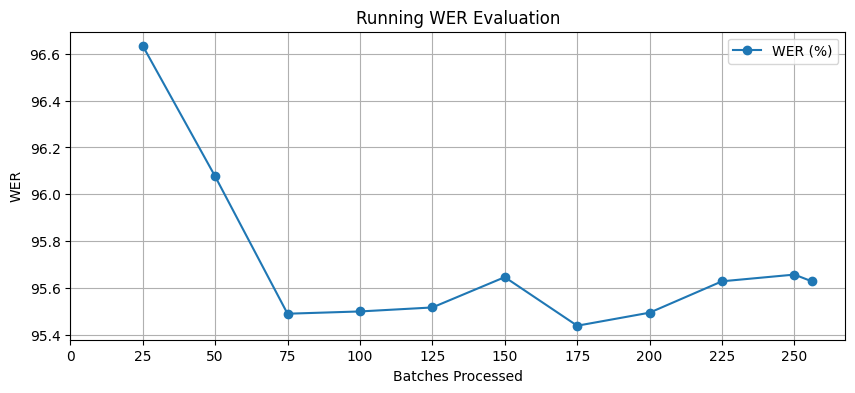

100%|██████████| 256/256 [1:04:24<00:00, 15.10s/it]


95.62871559174701

In [29]:
# Evaluate WER after the training
torch.cuda.empty_cache()
evaluation(loaded_model)

In [52]:
#-------------------------------Save the loaded model to hugging face------------------------
from transformers import WhisperForConditionalGeneration

# Push to Hugging Face Hub
loaded_model.push_to_hub("imonghose/whisper-small-bengali-lora-specaugment-final")



adapter_model.safetensors: 100%|██████████| 28.4M/28.4M [00:30<00:00, 923kB/s] 


CommitInfo(commit_url='https://huggingface.co/imonghose/whisper-small-bengali-lora-specaugment-final/commit/993d8b7cff4e64f3d63e6d3ddf80f18ef2e90420', commit_message='Upload model', commit_description='', oid='993d8b7cff4e64f3d63e6d3ddf80f18ef2e90420', pr_url=None, repo_url=RepoUrl('https://huggingface.co/imonghose/whisper-small-bengali-lora-specaugment-final', endpoint='https://huggingface.co', repo_type='model', repo_id='imonghose/whisper-small-bengali-lora-specaugment-final'), pr_revision=None, pr_num=None)

In [ ]:
#---------------------------------Reload the model from Hugging Face Hub-----------------------------------
# Load base model
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

peft_model = get_peft_model(base_model, config)
peft_model = get_peft_model(peft_model, config)
# loaded_model = get_peft_model(loaded_model, "trained_model")

# Load LoRA adapter
final_loaded_model = PeftModel.from_pretrained(peft_model, "imonghose/whisper-small-bengali-lora-specaugment-final")

# ✅ Move model to GPU
final_loaded_model = final_loaded_model.to("cuda")


In [54]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using trainer.model)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = trainer.model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : চুলতে পাইনা

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নিজর সজনে জনল

 
-------9------
True : সে যুদ্ধকেই 
Pred : শে জ্দ্দ কি

 


In [55]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using trainer.model)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : চুলতে পাইনা

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নিজর সজনে জনল

 
-------9------
True : সে যুদ্ধকেই 
Pred : শে জ্দ্দ কি

 


In [56]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from hugging face)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = final_loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : চুলতে পাইনা

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নিজর সজনে জনল

 
-------9------
True : সে যুদ্ধকেই 
Pred : শে জ্দ্দ কি

 


In [24]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from hugging face)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : চুলতে পাইনা

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নিজর সজনে জনল

 
-------9------
True : সে যুদ্ধকেই 
Pred : শে জ্দ্দ কি

 


In [ ]:
#------------------------CODE TO DELETE Loaded dataset from cache-------------------------

# !ls -lh ~/.cache/huggingface/datasets

# !rm -rf ~/.cache/huggingface/datasets/rootflo___bengali-asr-data
# !rm -rf ~/.cache/huggingface/datasets/_root_.cache_huggingface_datasets_rootflo___bengali-asr-data_default_0.0.0_bbea669d7678c71e778d0c20f4fbed55ea9bc0f7.lock

# !rm -rf ~/.cache/huggingface/
# !rm -rf ~/.cache/datasets/
# !rm -rf ~/.cache/torch/
# !rm -rf ~/.cache/

ls: cannot access '/root/.cache/huggingface/datasets': No such file or directory


In [ ]:
#-----------------------Check path where hugging face datasets are stored in cache--------------------
# from datasets import config
# config.HF_DATASETS_CACHE

WindowsPath('C:/Users/imong/.cache/huggingface/datasets')

In [71]:
#-------------------Code for Cleaning GPU Cache--------------------------
# import torch
# import gc

# gc.collect()  # Clean up RAM
# torch.cuda.empty_cache()  # Free GPU memory

# print("✅ GPU memory forcibly cleared!")


✅ GPU memory forcibly cleared!


In [53]:
#----------------Code to check stored huggingface dataset files in cache---------------
# !ls -lh ~/.cache/huggingface/datasets

total 4.0K
drwxr-xr-x 3 root root 4.0K Mar 17 21:31 imonghose___bengali-asr-data
-rw-r--r-- 1 root root    0 Mar 17 21:36 _root_.cache_huggingface_datasets_imonghose___bengali-asr-data_default_0.0.0_3a297ddede51b3012d3a6eb39e9dbea12b8ccc40.lock


In [ ]:
#-------------------Check if a checkpoint file exists-----------------------
# ls -lh checkpoints/checkpoint-1197
# checkpoint_path = get_last_checkpoint("checkpoints")
# checkpoint_path